In [ ]:
%pip install -q llama-index-vector-stores-qdrant

In [ ]:
%pip install llama_index ftfy regex tqdm
%pip install git+https://github.com/openai/CLIP.git
%pip install torch torchvision
%pip install matplotlib scikit-image
%pip install -U qdrant_client

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-lejvx_0s
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-lejvx_0s
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [ ]:
!pip install llama-index-embeddings-clip

Parsing wikipedia articles and saving into local folder

In [ ]:
from pathlib import Path
import requests

wiki_titles = [
    "RoboCop",
    "Labour Party (UK)",
    "SpaceX",
    "OpenAI",
]


data_path = Path("data_wiki")

for title in wiki_titles:
    response = requests.get(
        "https://en.wikipedia.org/w/api.php",
        params={
            "action": "query",
            "format": "json",
            "titles": title,
            "prop": "extracts",
            "explaintext": True,
        },
    ).json()
    page = next(iter(response["query"]["pages"].values()))
    wiki_text = page["extract"]

    if not data_path.exists():
        Path.mkdir(data_path)

    with open(data_path / f"{title}.txt", "w") as fp:
        fp.write(wiki_text)

Parsing Wikipedia Images and texts and loading into local folder

In [ ]:
!pip install wikipedia

In [ ]:
import wikipedia
import urllib.request

image_path = Path("data_wiki")
image_uuid = 0
# image_metadata_dict stores images metadata including image uuid, filename and path
image_metadata_dict = {}
MAX_IMAGES_PER_WIKI = 30

wiki_titles = [
    "RoboCop",
    "Labour Party (UK)",
    "SpaceX",
    "OpenAI",
]

# create folder for images only
if not image_path.exists():
    Path.mkdir(image_path)


# Download images for wiki pages
# Assing UUID for each image
for title in wiki_titles:
    images_per_wiki = 0
    print(title)
    try:
        page_py = wikipedia.page(title)
        list_img_urls = page_py.images
        for url in list_img_urls:
            if url.endswith(".jpg") or url.endswith(".png"):
                image_uuid += 1
                image_file_name = title + "_" + url.split("/")[-1]

                # img_path could be s3 path pointing to the raw image file in the future
                image_metadata_dict[image_uuid] = {
                    "filename": image_file_name,
                    "img_path": "./" + str(image_path / f"{image_uuid}.jpg"),
                }
                urllib.request.urlretrieve(
                    url, image_path / f"{image_uuid}.jpg"
                )
                images_per_wiki += 1
                # Limit the number of images downloaded per wiki page to 15
                if images_per_wiki > MAX_IMAGES_PER_WIKI:
                    break
    except:
        print(str(Exception("No images found for Wikipedia page: ")) + title)
        continue

RoboCop
Labour Party (UK)
No images found for Wikipedia page: Labour Party (UK)
SpaceX
No images found for Wikipedia page: SpaceX
OpenAI
No images found for Wikipedia page: OpenAI


In [ ]:
import os

from google.colab import userdata

os.environ["first"] = userdata.get('first')

In [ ]:
!pip install llama-index-embeddings-huggingface

Building Multi Modal Vector Store using Text and Image embeddings under different collections

In [ ]:
import qdrant_client
from llama_index.core import SimpleDirectoryReader
from llama_index.vector_stores.qdrant import QdrantVectorStore
from llama_index.core import VectorStoreIndex, StorageContext
from llama_index.core.indices import MultiModalVectorStoreIndex

# Create a local Qdrant vector store
client = qdrant_client.QdrantClient(path="qdrant_d_1")

text_store = QdrantVectorStore(
    client=client, collection_name="text_collection_0"
)
image_store = QdrantVectorStore(
    client=client, collection_name="image_collection_0"
)

storage_context = StorageContext.from_defaults(
    vector_store=text_store, image_store=image_store
)

# Create the MultiModal index
documents = SimpleDirectoryReader("./data_wiki/").load_data()
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-small-en")
index = MultiModalVectorStoreIndex.from_documents(
    documents,
    storage_context=storage_context,
    embed_model=embed_model
)

/usr/local/lib/python3.11/dist-packages/llama_index/vector_stores/qdrant/base.py:644: UserWarning: Payload indexes have no effect in the local Qdrant. Please use server Qdrant if you need payload indexes.
  self._client.create_payload_index(


Plotting downloaded Images from Wikipedia

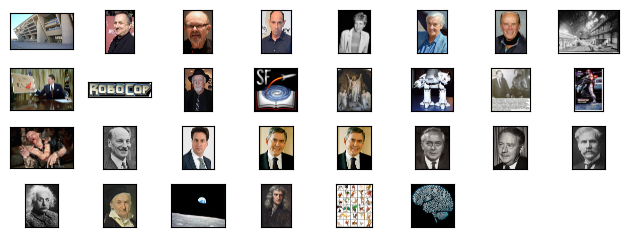

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import os


def plot_images(image_metadata_dict):
    original_images_urls = []
    images_shown = 0
    for image_id in image_metadata_dict:
        img_path = image_metadata_dict[image_id]["img_path"]
        if os.path.isfile(img_path):
            filename = image_metadata_dict[image_id]["filename"]
            image = Image.open(img_path).convert("RGB")

            plt.subplot(8, 8, len(original_images_urls) + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            original_images_urls.append(filename)
            images_shown += 1
            if images_shown >= 64:
                break

    plt.tight_layout()


plot_images(image_metadata_dict)

Building a separate CLIP image embedding index under a different collection wikipedia_img

In [ ]:
def plot_images(image_paths):
    images_shown = 0
    plt.figure(figsize=(16, 9))
    for img_path in image_paths:
        if os.path.isfile(img_path):
            image = Image.open(img_path)

            plt.subplot(2, 3, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images_shown += 1
            if images_shown >= 9:
                break

Multi-Modal retrieval results for some queries

In [ ]:
test_query = "what is the Labour Party?"
# generate  retrieval results
retriever = index.as_retriever(similarity_top_k=3, image_similarity_top_k=5)
retrieval_results = retriever.retrieve(test_query)

In [ ]:
retrieval_results

[NodeWithScore(node=TextNode(id_='0b838dc2-1731-40d9-92ad-79e2cbf3f836', embedding=None, metadata={'file_path': '/content/data_wiki/Labour Party (UK).txt', 'file_name': 'Labour Party (UK).txt', 'file_type': 'text/plain', 'file_size': 50096, 'creation_date': '2025-02-19', 'last_modified_date': '2025-02-19'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='9219b540-3d5c-4ccf-97e9-a977a1340206', node_type='4', metadata={'file_path': '/content/data_wiki/Labour Party (UK).txt', 'file_name': 'Labour Party (UK).txt', 'file_type': 'text/plain', 'file_size': 50096, 'creation_date': '2025-02-19', 'last_modified_date': '2025-02-19'}, hash='841249f011a7d902a60b187e161bde10c475dd0872d69452f5708e127786258c'), <NodeRelati

**Node ID:** 0b838dc2-1731-40d9-92ad-79e2cbf3f836<br>**Similarity:** 0.9266515440753745<br>**Text:** The Labour Party is a political party in the United Kingdom that sits on the centre-left of the political spectrum. The party has been described as an alliance of social democrats, democratic socia...<br>

**Node ID:** 5fc59206-1582-4932-954f-869dc7611033<br>**Similarity:** 0.901130139433769<br>**Text:** == Constitution and structure ==

The Labour Party is a membership organisation consisting of individual members and constituency Labour parties, affiliated trade unions, socialist societies and th...<br>

**Node ID:** 5e161627-4424-4514-bd40-2f4755d28e5c<br>**Similarity:** 0.8993014559725379<br>**Text:** === Trade union link ===

The Trade Union and Labour Party Liaison Organisation is the co-ordinating structure that supports the policy and campaign activities of affiliated union members within th...<br>

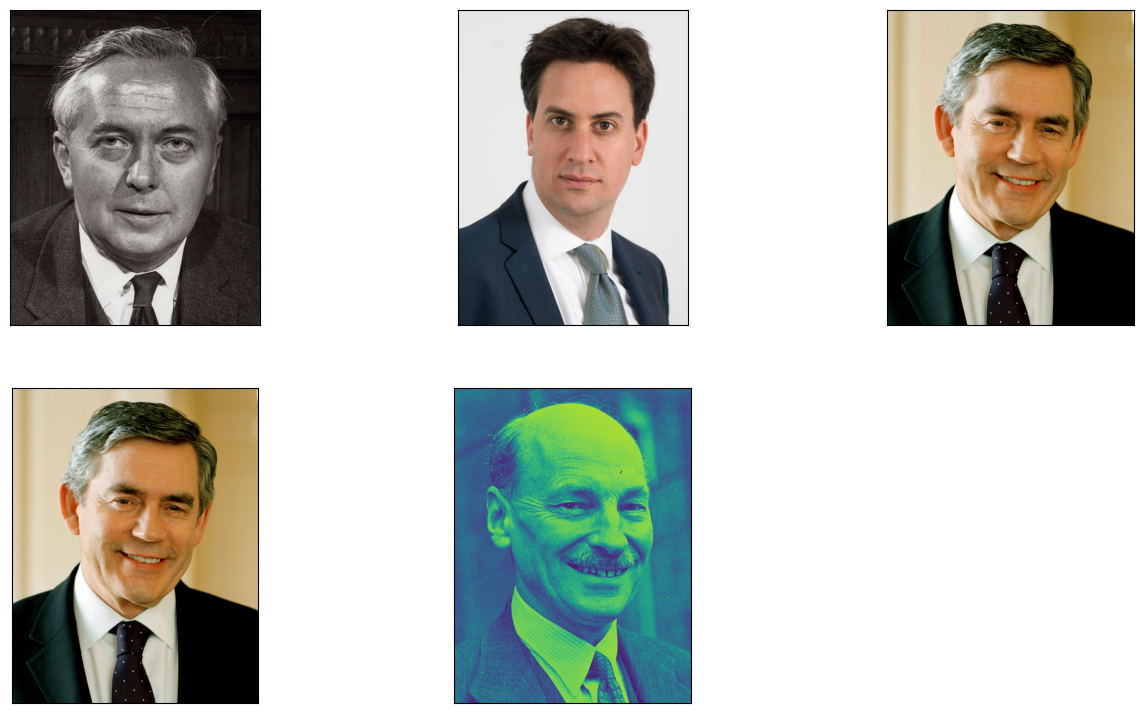

In [ ]:
from llama_index.core.response.notebook_utils import display_source_node
from llama_index.core.schema import ImageNode

retrieved_image = []
for res_node in retrieval_results:
    if isinstance(res_node.node, ImageNode):
        retrieved_image.append(res_node.node.metadata["file_path"])
    else:
        display_source_node(res_node, source_length=200)

plot_images(retrieved_image)

**Node ID:** b745bc5b-59a5-4a83-938a-f62dbaae95ea<br>**Similarity:** 0.8917081738362822<br>**Text:** RoboCop is a 1987 American science fiction action film directed by Paul Verhoeven and written by Edward Neumeier and Michael Miner. The film stars Peter Weller, Nancy Allen, Daniel O'Herlihy, Ronny...<br>

**Node ID:** 85bee284-8ed9-4d60-bb9d-a2580d732b32<br>**Similarity:** 0.8684134696087061<br>**Text:** == Cast ==

Peter Weller as Alex Murphy / RoboCop: A Detroit police officer murdered in the line of duty and revived as a cyborg
Nancy Allen as Anne Lewis: A tough and loyal police officer
Daniel O...<br>

**Node ID:** 63b1c708-b21c-40a6-ba0b-175301036531<br>**Similarity:** 0.8666358348564953<br>**Text:** === Accolades ===
RoboCop received a Special Achievement for Best Sound Editing (Stephen Flick and John Pospisil) at the 60th Academy Awards. The film had two other nominations: Best Film Editing f...<br>

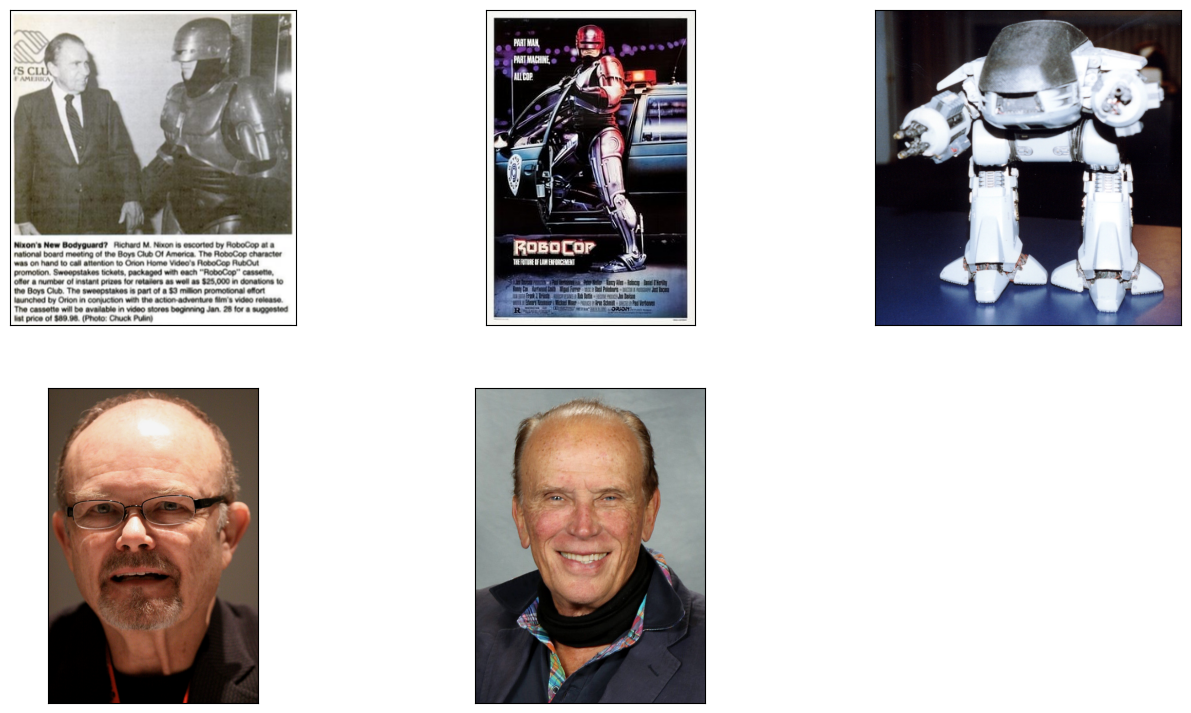

In [ ]:
test_query = "Who created RoboCop?"
# generate  retrieval results
retriever = index.as_retriever(similarity_top_k=3, image_similarity_top_k=5)
retrieval_results = retriever.retrieve(test_query)

retrieved_image = []
for res_node in retrieval_results:
    if isinstance(res_node.node, ImageNode):
        retrieved_image.append(res_node.node.metadata["file_path"])
    else:
        display_source_node(res_node, source_length=200)

plot_images(retrieved_image)

**Node ID:** e2cf909e-0613-4116-8876-8e23da95e16e<br>**Similarity:** 0.8983243976981609<br>**Text:** OpenAI, Inc. is an American artificial intelligence (AI) research organization founded in December 2015 and headquartered in San Francisco, California. It aims to develop "safe and beneficial" arti...<br>

**Node ID:** 927b39b6-f95d-4958-992c-968c40cc0b01<br>**Similarity:** 0.8731904641421313<br>**Text:** == Products and applications ==


=== Reinforcement learning ===
At its beginning, OpenAI's research included many projects focused on reinforcement learning (RL). OpenAI has been viewed as an impo...<br>

**Node ID:** 42e0e407-781b-4ee2-8c5b-1556505bf73b<br>**Similarity:** 0.8618625436204477<br>**Text:** In December 2024, OpenAI launched several significant features as part of its "12 Days of OpenAI" event, which started on December 5. It announced Sora, a text-to-video model intended to create rea...<br>

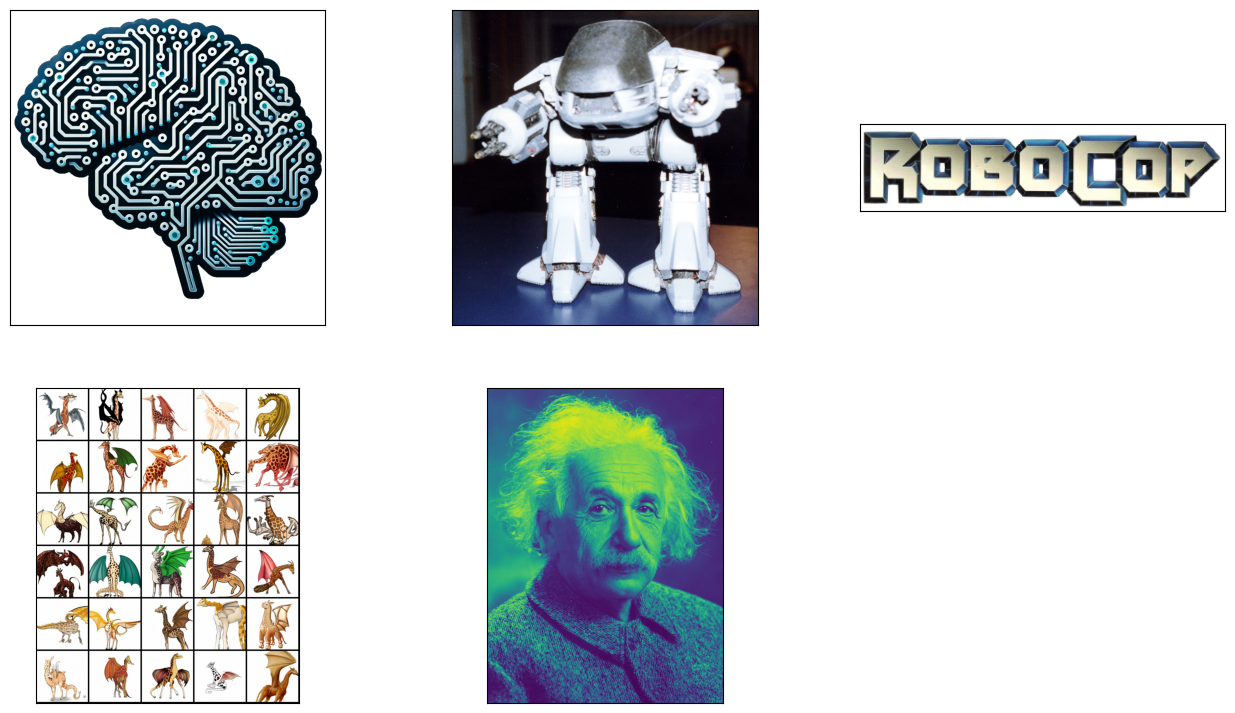

In [ ]:
test_query = "What does OpenAI do?"
# generate  retrieval results
retriever = index.as_retriever(similarity_top_k=3, image_similarity_top_k=5)
retrieval_results = retriever.retrieve(test_query)

retrieved_image = []
for res_node in retrieval_results:
    if isinstance(res_node.node, ImageNode):
        retrieved_image.append(res_node.node.metadata["file_path"])
    else:
        display_source_node(res_node, source_length=200)

plot_images(retrieved_image)

**Node ID:** 50b286e4-95a1-47fc-ad7b-e2aba147dc75<br>**Similarity:** 0.8305322648362287<br>**Text:** === Other ===
In July 2018, Musk arranged for his employees to build a mini-submarine to assist the rescue of children stuck in a flooded cavern in Thailand. Richard Stanton, leader of the internat...<br>

**Node ID:** da25d6f0-e2e5-41d2-9632-8bd3b048d75a<br>**Similarity:** 0.8227603127259133<br>**Text:** == Management ==


=== Key employees ===
CEO and co-founder: Sam Altman, former president of the startup accelerator Y Combinator
President and co-founder: Greg Brockman, former CTO, 3rd employee o...<br>

**Node ID:** e8af5b80-c8a3-4c85-a77a-67f7b99e465b<br>**Similarity:** 0.8203270023334582<br>**Text:** === 2005–2009: Falcon 1 and first orbital launches ===

SpaceX developed its first orbital launch vehicle, the Falcon 1, with internal funding. The Falcon 1 was an expendable two-stage-to-orbit sma...<br>

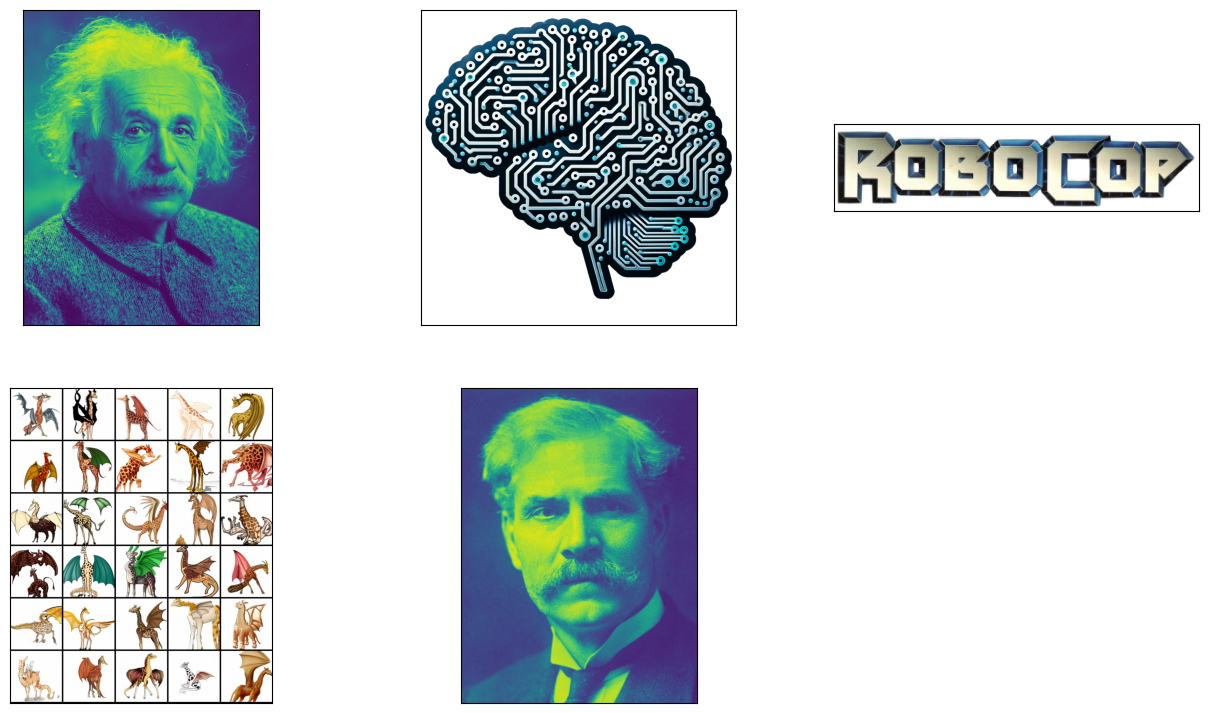

In [ ]:
test_query = "which company makes Tesla"
# generate  retrieval results
retriever = index.as_retriever(similarity_top_k=3, image_similarity_top_k=5)
retrieval_results = retriever.retrieve(test_query)

retrieved_image = []
for res_node in retrieval_results:
    if isinstance(res_node.node, ImageNode):
        retrieved_image.append(res_node.node.metadata["file_path"])
    else:
        display_source_node(res_node, source_length=200)

plot_images(retrieved_image)